# comparison of Green-Ampt approaches

- landlab component

and

- Green-Ampt by Peishi Jiang (https://github.com/csdms-contrib/GreenAmptInfiltrationModel/blob/master/GreenAmpt.py)

## import both models
(GreenAmpt is forked and made compatible to python 3)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from landlab import RasterModelGrid
from landlab.components import SoilInfiltrationGreenAmpt

import GreenAmpt

## set input values

In [2]:
# intensity [m/s] (first value is intensity in mm/min, then converted)
intens = 1 /1000 /60

# matrix potential [m]
psi = 0.25
# hydraulic conductivity [m/s]
ks = 0.000008
# fraction of unfilled porevolume [-]
delta_theta = 0.2557

#set number of time steps
steps = 120
# length of time steps [s]
dt = 60

## run landlab component

GA_landlab is the diff of soil water infiltration depth - this equals the infiltrated volume per timestep

In [3]:
mg = RasterModelGrid((1,1), xy_spacing=1.)
h = mg.add_zeros("surface_water__depth", at="node")
d = mg.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
d *= 1e-8

SI = SoilInfiltrationGreenAmpt(mg,hydraulic_conductivity=ks, wetting_front_capillary_pressure_head = psi)
SI.moisture_deficit = delta_theta

result = []
for i in range(int(steps)+1):  

#available water in timestep is intensity by timestep length
  h += intens * dt
  #print(h)
#  SI._grid.at_node["soil_water_infiltration__depth"] / SI._moisture_deficit
  SI.run_one_step(dt)
  result.append(mg.at_node['soil_water_infiltration__depth'][0])

GA_landlab = np.diff(result)

## run Green-Ampt by Peishi

GA_Peishi is diff of infiltration depth according to GA_landlab

unit conversion is done according to specification in documentation

In [4]:
# convert [m/s] to [cm/h]
K = ks * 100 * 3600

# convert [m] to [cm]
psi_cm = psi * 100

# redefine delta theta
di = 0.2; ds = di + delta_theta; 

# timestep length from [s] to [h]
dt_h = dt/3600

# create list with intensities over timesteps
# convert [m/s] to [cm/h]
i = [intens*100*3600] * int(steps)

# run model
a = GreenAmpt.GreenAmpt(K, dt_h, di, ds, psi_cm, i)
F, f, t =a.F_f()

# convert [cm] to [m]
GA_Peishi = np.diff(F)/100

## plot infiltration

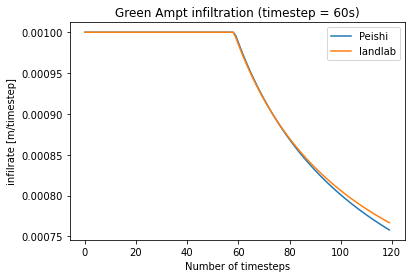

In [5]:
plt.plot(GA_Peishi, label ='Peishi')
plt.plot(GA_landlab, label ='landlab')
plt.legend()
plt.ylabel('infilrate [m/timestep]')
plt.xlabel('Number of timesteps')
plt.title('Green Ampt infiltration (timestep = '+str(dt)+'s)')
plt.show()